In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nglview as nv
import math

import MDAnalysis as mda
import MDAnalysis.analysis.rdf
import mdtraj as md

/opt/homebrew/anaconda3/envs/openmm/lib/python3.8/site-packages/simtk/__init__.py:2: UserWarning: 
You are using an experimental build of OpenMM v7.5.1.
This is NOT SUITABLE for production!
It has not been properly tested on this platform and we cannot guarantee it provides accurate results.

  warnings.warn("""


In [2]:
x_residue = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE','LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL']
nonpolar_residue = ['ALA', 'GLY', 'ILE', 'LEU', 'MET', 'PHE', 'PRO', 'TRP', 'VAL']
polar_residue = ['ASN', 'CYS', 'GLN', 'SER', 'THR', 'TYR']
acid_residue = ['ASP', 'GLU']
base_residue = ['ARG', 'HIS', 'LYS']
sample_residue = ['ALA', 'ARG', 'ASN', 'SER', 'TRP', 'TYR', 'GLY'] #Contains an interesting mix of residues
figure_index = 0
rdf_methods = ['all_all', 'ca_all', 'ca_base', 'ca_po4', 'ca_sugar', 'side_all', 'side-end_all', 'side-end_base', 'side-end_po4', 'side-end_sugar']
rdf_ca_methods = ['ca_all', 'ca_base', 'ca_po4', 'ca_sugar']
rdf_side_end_methods = ['side-end_all', 'side-end_base', 'side-end_po4', 'side-end_sugar']


In [3]:
def show_simulation(residue, no_HOH=True):
    if(no_HOH):
        top_file = "../" + residue + "/output_no_HOH.pdb"
        traj_file = "../" + residue + "/traj_no_HOH.dcd"
    else:
        top_file = "../" + residue + "/gromacs/output.gro"
        traj_file = "../" + residue + "/trajectory.dcd"
    univ = mda.Universe(top_file, traj_file)
    view = nv.show_mdanalysis(univ)
    view.clear_representations()
    view.add_representation('ball+stick', selection='protein')
    view.add_representation('ball+stick', selection='nucleic')
    return view

# Plots the potential energy for a simulation for one residue
def plot_PE(residue):
    log = pd.read_csv("../" + residue + "/log.txt", sep='\t')
    global figure_index
    plt.figure(figure_index)
    figure_index+=1
    log.plot(kind='line', x="Step", y='Potential Energy (kJ/mole)')
    plt.show()

# Makes a dictionary using the output from one rdf method for every residue
def make_dict(filename, residue_list):
    data_list = list()
    for x in residue_list:
        file_name = x + "/" + filename
        data_df = pd.read_csv(file_name)
        data_list.append(data_df)
    data_dict = {}
    for i, x in enumerate(residue_list):
        data_dict[x] = data_list[i]
    return data_dict

# Makes a dictionary using output from each rdf method for a single residue
def make_res_dict(method_list, residue):
    data_list = list()
    for method in method_list:
        file_name = residue + "/rdf_" + method + ".csv"
        data_df = pd.read_csv(file_name)
        column_name = "RDF_" + residue
        data_df.rename(columns={column_name: "RDF_" + method}, inplace=True)
        data_list.append(data_df)
    data_dict = {}
    for i, x in enumerate(method_list):
        data_dict[x] = data_list[i]
    return data_dict

<Figure size 640x480 with 0 Axes>

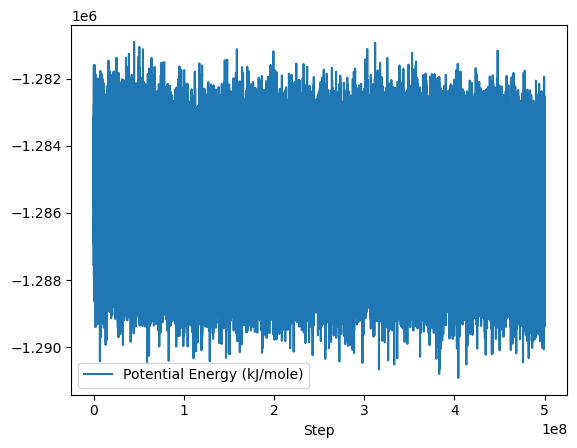

In [4]:
plot_PE("ALA")

In [5]:
show_simulation("ALA")

NGLWidget(max_frame=49999)

In [6]:
def rdf_stack_graph(rdf_dict, residue_list, height=10, width=10, 
                    x_range = [0,25], y_range = [0,10], save_path = False):
    for i, x in enumerate(residue_list):
        if(i==0):
            temp_df = rdf_dict[x].rename(columns={'RDF_' + x:x})
        else:
            temp_df[x] = rdf_dict[x]['RDF_' + x]
    global figure_index
    plt.figure(figure_index)
    figure_index+=1
    temp_df.plot(x="Radius", figsize=(width ,height))
    axes = plt.gca()
    axes.set_ylim(y_range)
    axes.set_xlim(x_range)
    if(save_path):
        plt.savefig(save_path)

def rdf_split_graph(rdf_dict, residue_list, n_cols=2, height=20, width=10, 
                    x_range = [0,25], y_range = [0,10], save_path = False, compare = False):
    global figure_index
    plt.figure(figure_index)
    figure_index+=1
    fig, axes = plt.subplots(nrows = math.ceil(len(residue_list)/n_cols), ncols=n_cols)
    fig.set_size_inches(width,height)
    for i, x in enumerate(residue_list):
        temp_df = rdf_dict[x].rename(columns={'RDF_' + x:x})
        if(compare):
            temp_df[compare] = rdf_dict[compare]['RDF_' + compare]
        temp_df.plot(ax=axes[int(i/2),(i)%2], x="Radius")
        axes[int(i/2),(i)%2].set_ylim(y_range)
        axes[int(i/2),(i)%2].set_xlim(x_range)
    if(save_path):
        plt.savefig(save_path)
        
def rdf_max(xdf_dict):
    df = pd.DataFrame(columns=['Residue', 'Radius', 'RDF'])
    for x in xdf_dict:
        rdfidxmax = xdf_dict[x].iloc[:,1].idxmax()
        rdfradiusmax = xdf_dict[x].iloc[rdfidxmax,0]
        rdfmax = xdf_dict[x].iloc[:,1].max()
        row = [x, rdfradiusmax, rdfmax]
        df.loc[len(df)] = row
    return df

def rdf_index(xdf_dict, index):
    df = pd.DataFrame(columns=['Residue', 'RDF'])
    for x in xdf_dict:
        row = [x, xdf_dict[x].iloc[index,1]]
        df.loc[len(df)] = row
    return df


def g_pmf(rdf):
    return -np.log(rdf)*(300)*(0.0083144621)

def rdf_to_PMF(rdf, radius, box_length):
    return rdf*(4/3*math.pi*(radius**3))/(box_length**3)

def display_results(rdf_dict, verbose=False):
    rdf_split_graph(rdf_dict, x_residue, compare = "ARG")
    if(verbose):
        rdf_stack_graph(rdf_dict, nonpolar_residue)
        rdf_stack_graph(rdf_dict, polar_residue)
        rdf_stack_graph(rdf_dict, acid_residue)
        rdf_stack_graph(rdf_dict, base_residue)
        rdf_stack_graph(rdf_dict, sample_residue)
        rdf_stack_graph(rdf_dict, sample_residue, x_range=[0,3])
    
def display_res_results(rdf_dict, verbose=False):
    rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
    rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5)
    

## All - All

<Figure size 640x480 with 0 Axes>

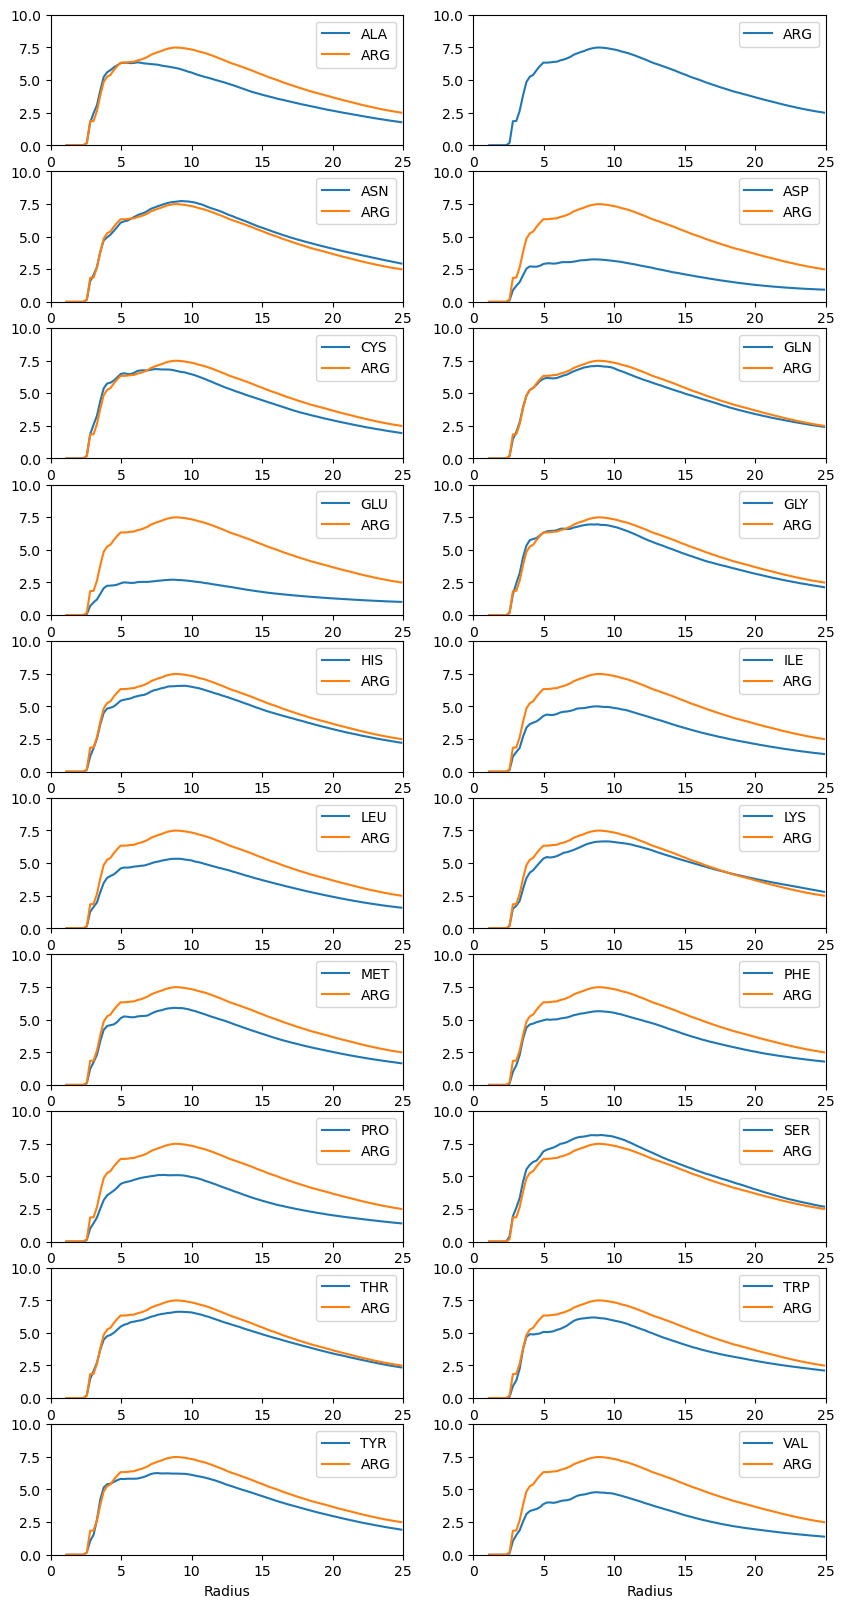

In [7]:
rdf_dict = make_dict("rdf_all_all.csv", x_residue)
display_results(rdf_dict)

## Ca - All

<Figure size 640x480 with 0 Axes>

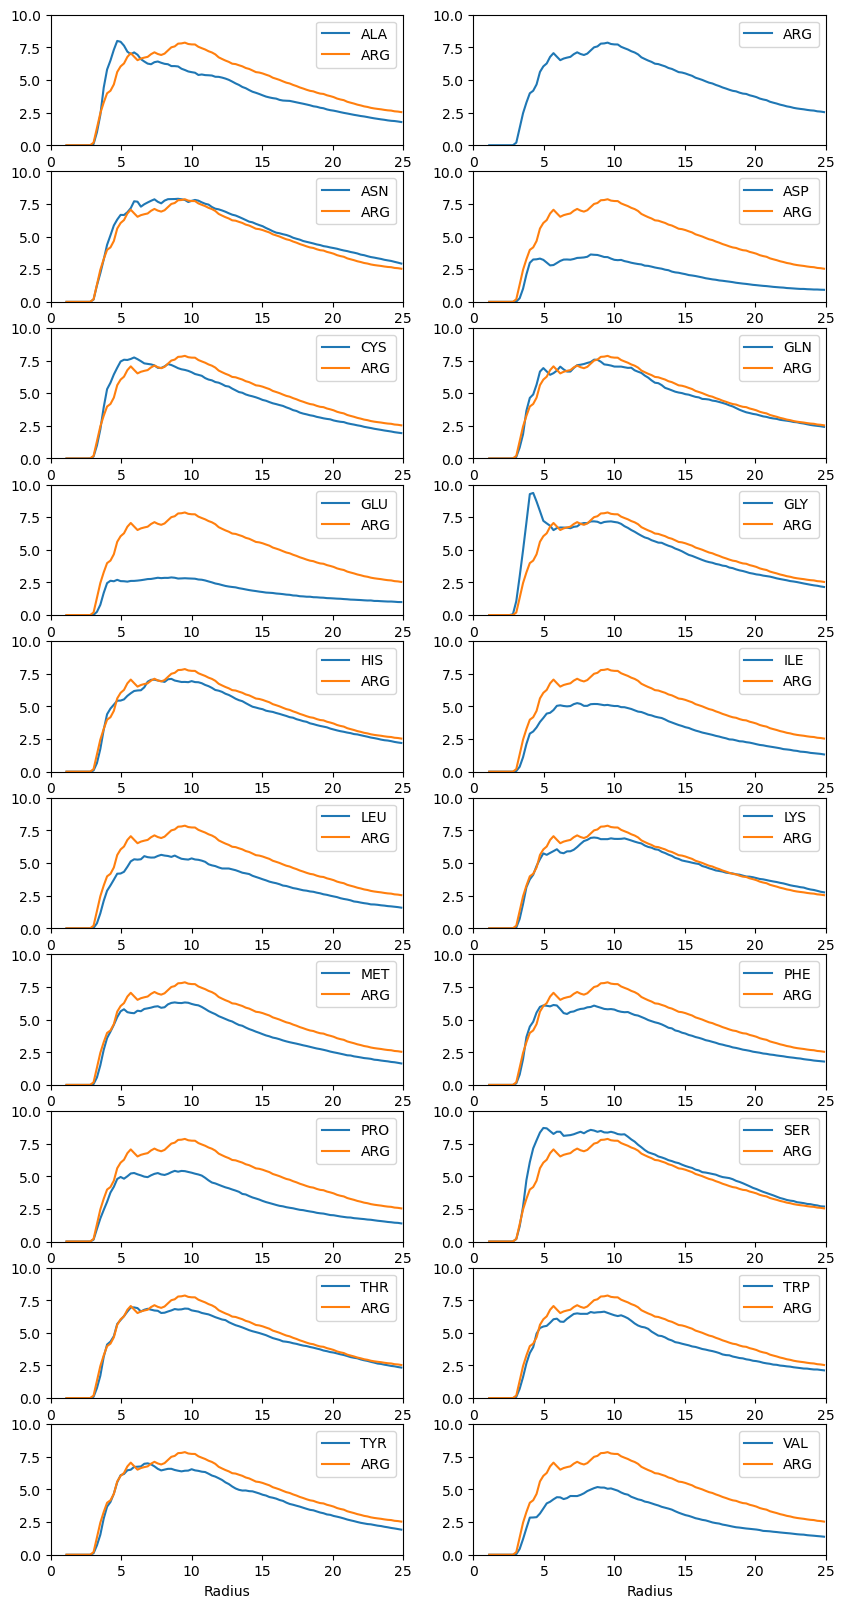

In [8]:
rdf_dict = make_dict("rdf_ca_all.csv", x_residue)
display_results(rdf_dict)

## Ca - Base

<Figure size 640x480 with 0 Axes>

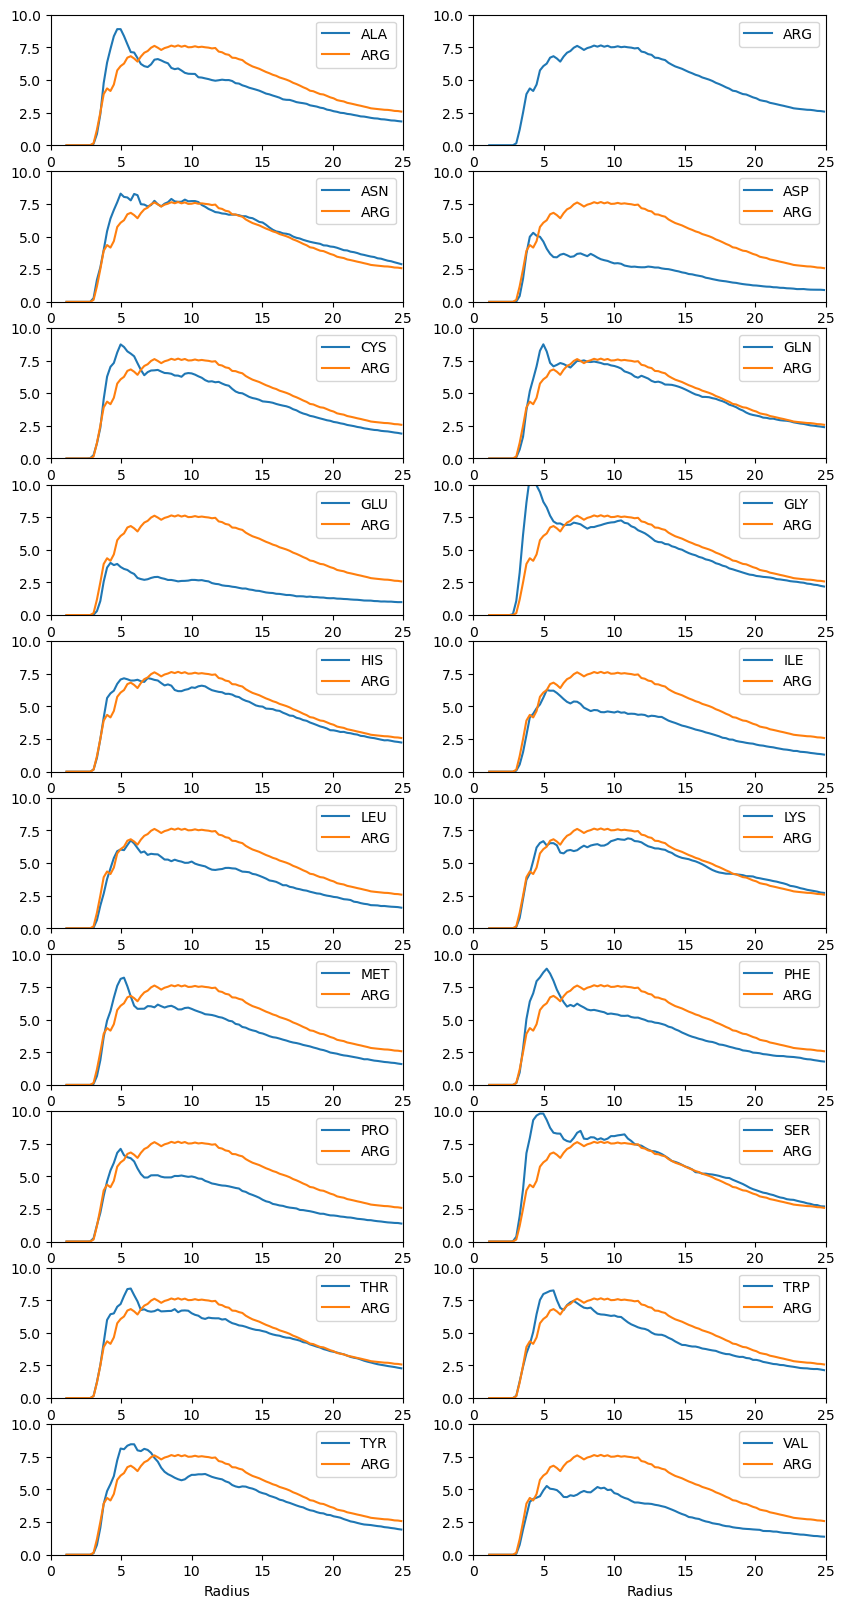

In [9]:
rdf_dict = make_dict("rdf_ca_base.csv", x_residue)
display_results(rdf_dict)

## Ca - PO4

<Figure size 640x480 with 0 Axes>

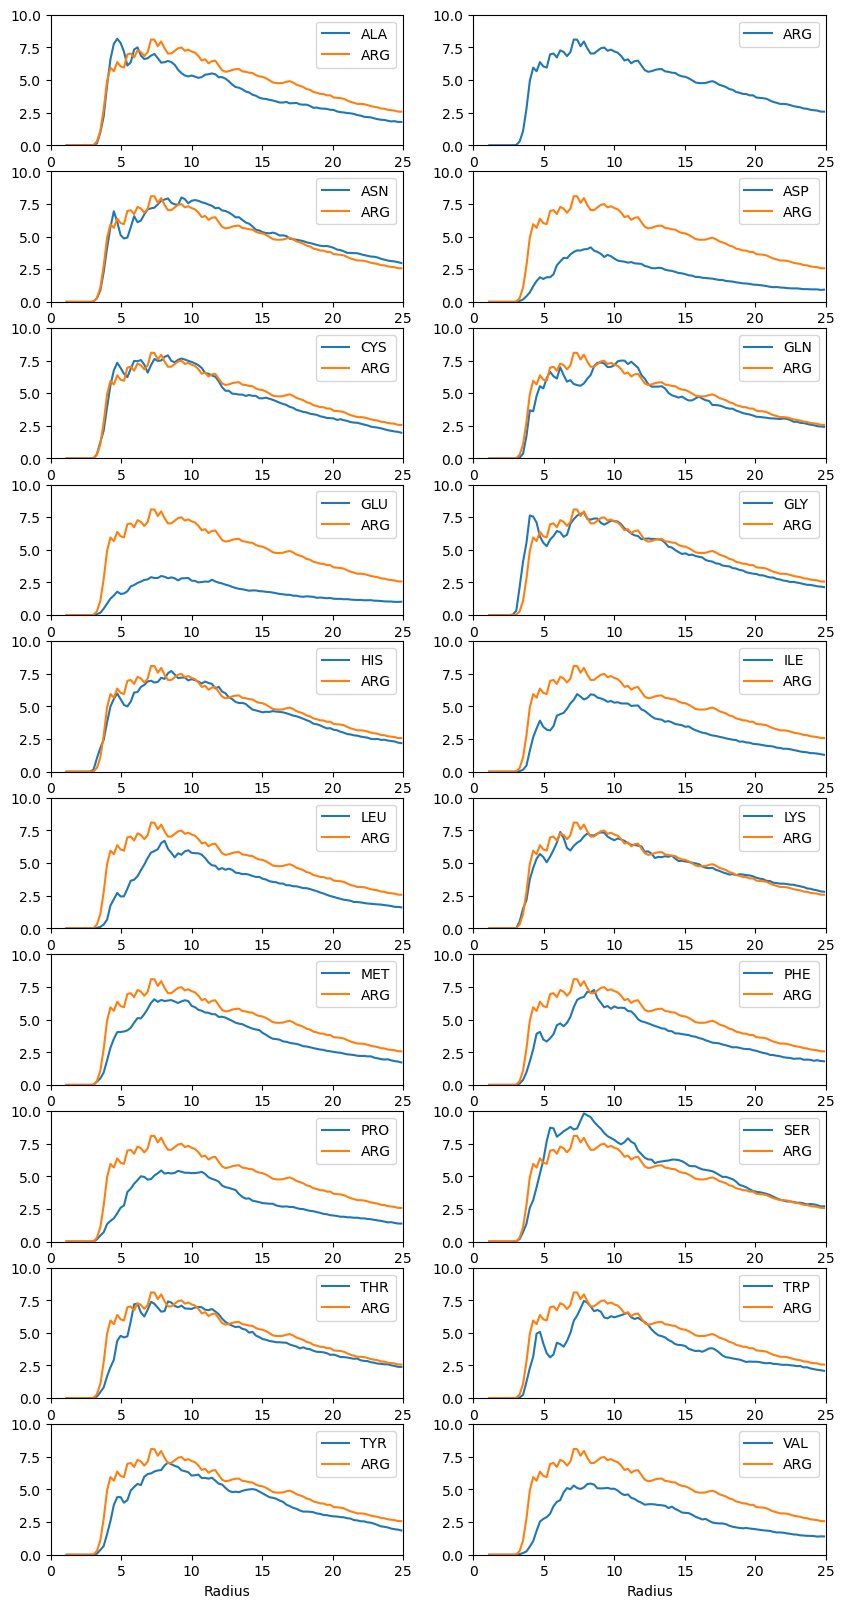

In [10]:
rdf_dict = make_dict("rdf_ca_po4.csv", x_residue)
display_results(rdf_dict)

## Ca - Sugar

<Figure size 640x480 with 0 Axes>

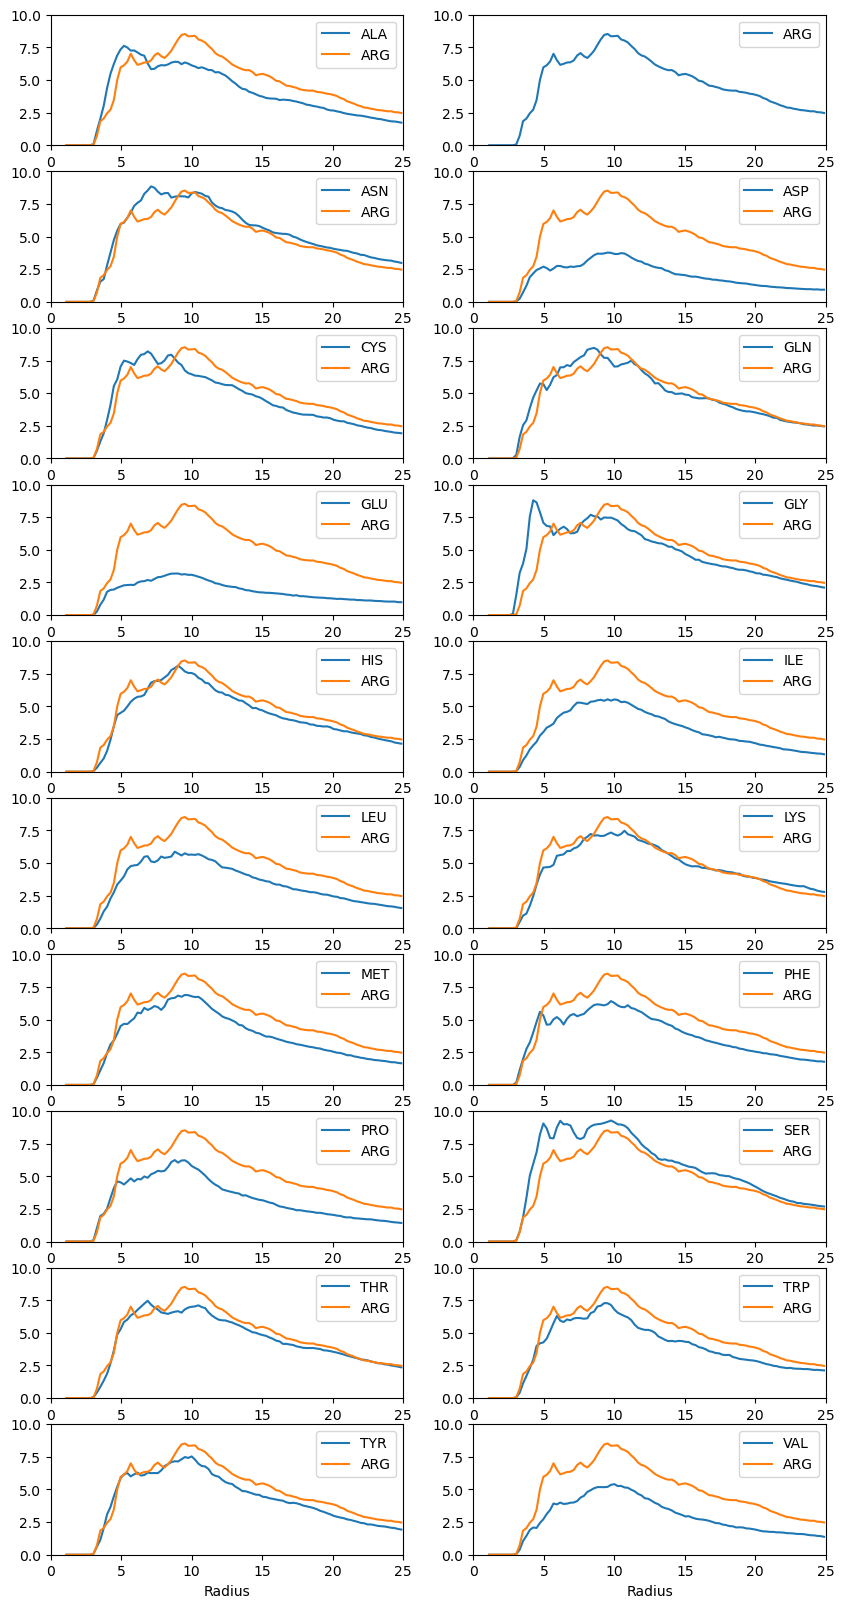

In [11]:
rdf_dict = make_dict("rdf_ca_sugar.csv", x_residue)
display_results(rdf_dict)

## Side-end - All

<Figure size 640x480 with 0 Axes>

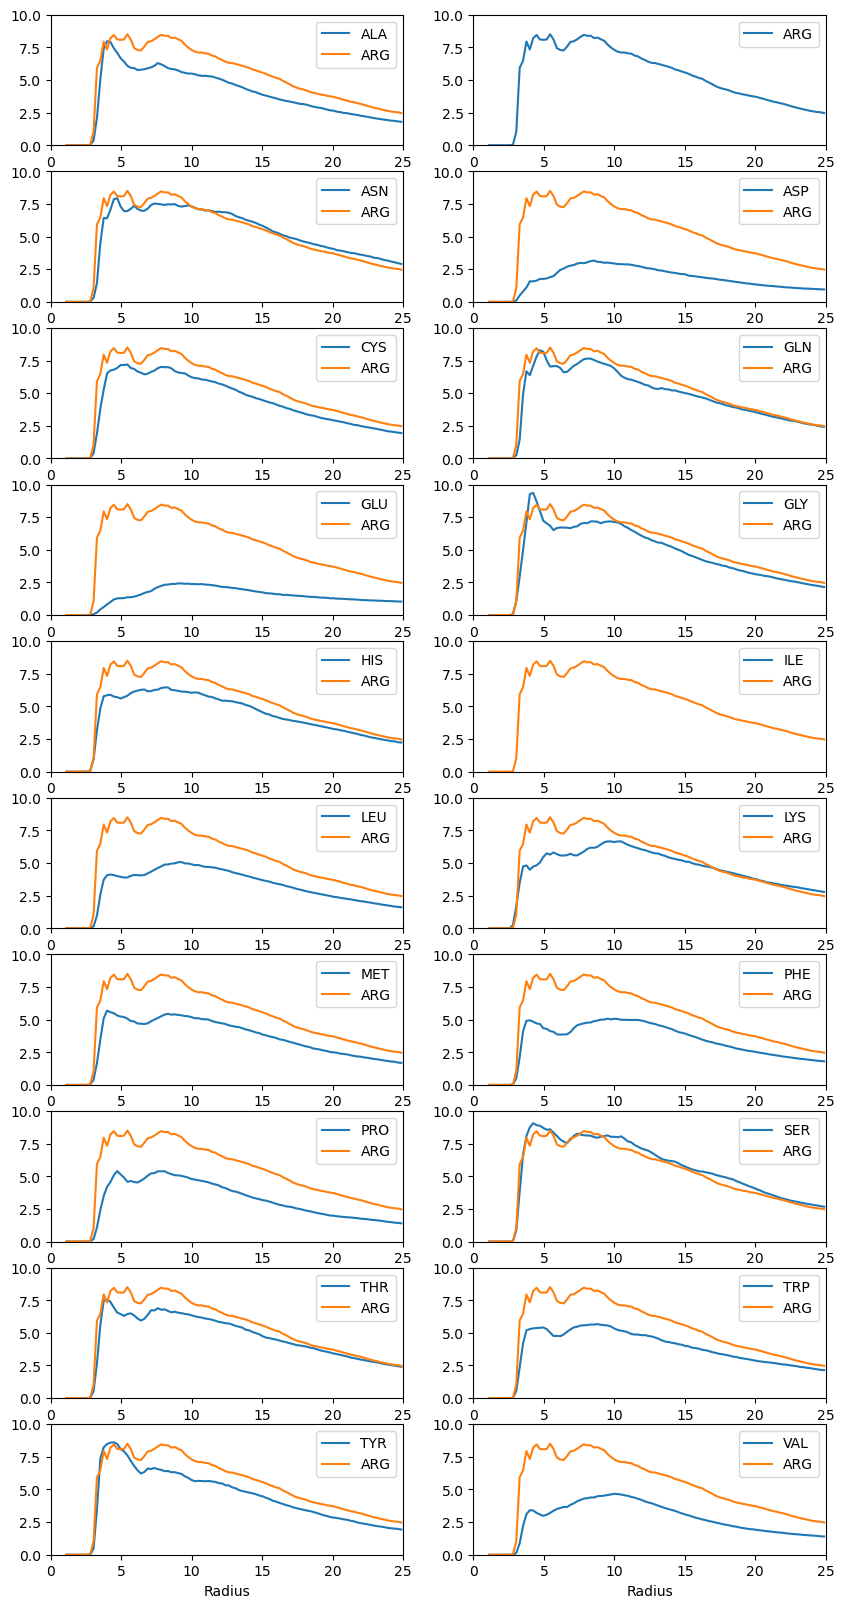

In [12]:
rdf_dict = make_dict("rdf_side-end_all.csv", x_residue)
display_results(rdf_dict)

## Side-end - Base

<Figure size 640x480 with 0 Axes>

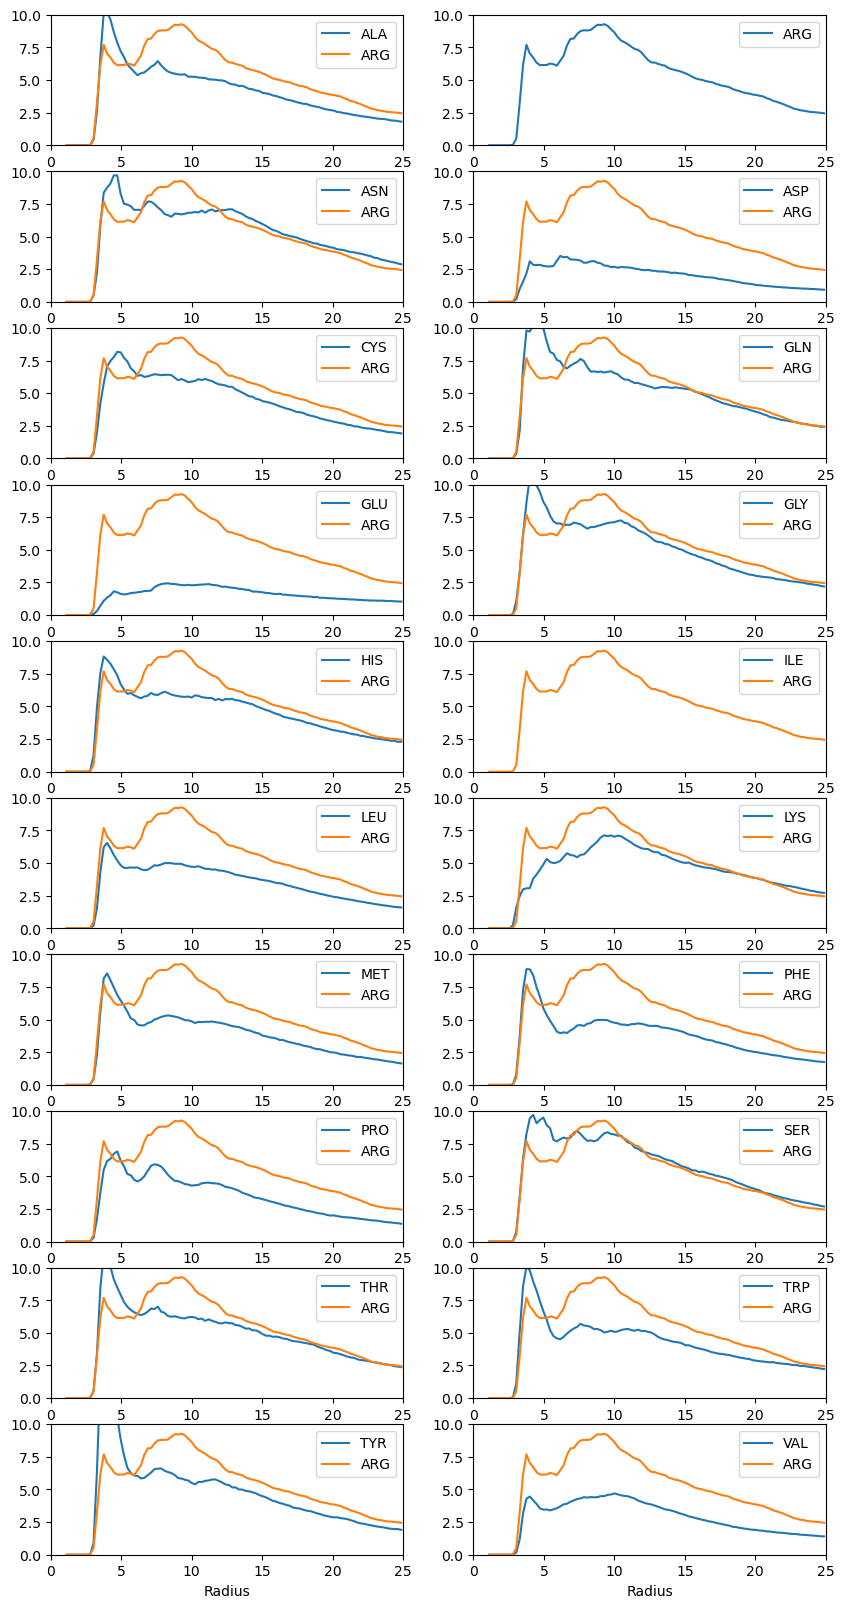

In [13]:
rdf_dict = make_dict("rdf_side-end_base.csv", x_residue)
display_results(rdf_dict)

## Side-end - Sugar

<Figure size 640x480 with 0 Axes>

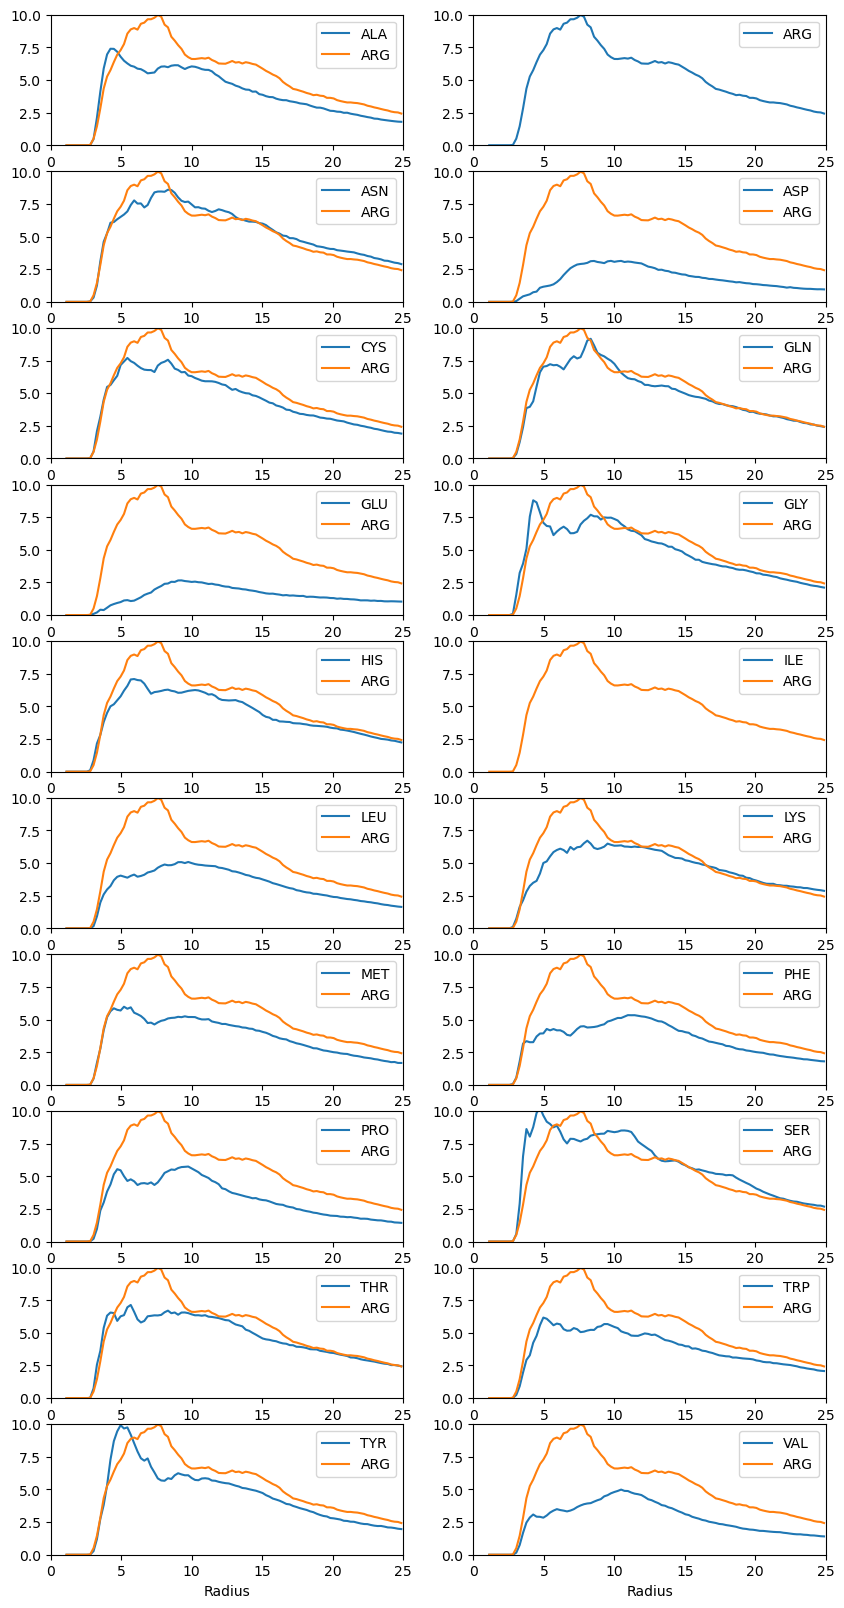

In [14]:
rdf_dict = make_dict("rdf_side-end_sugar.csv", x_residue)
display_results(rdf_dict)

## Side-end - PO4

<Figure size 640x480 with 0 Axes>

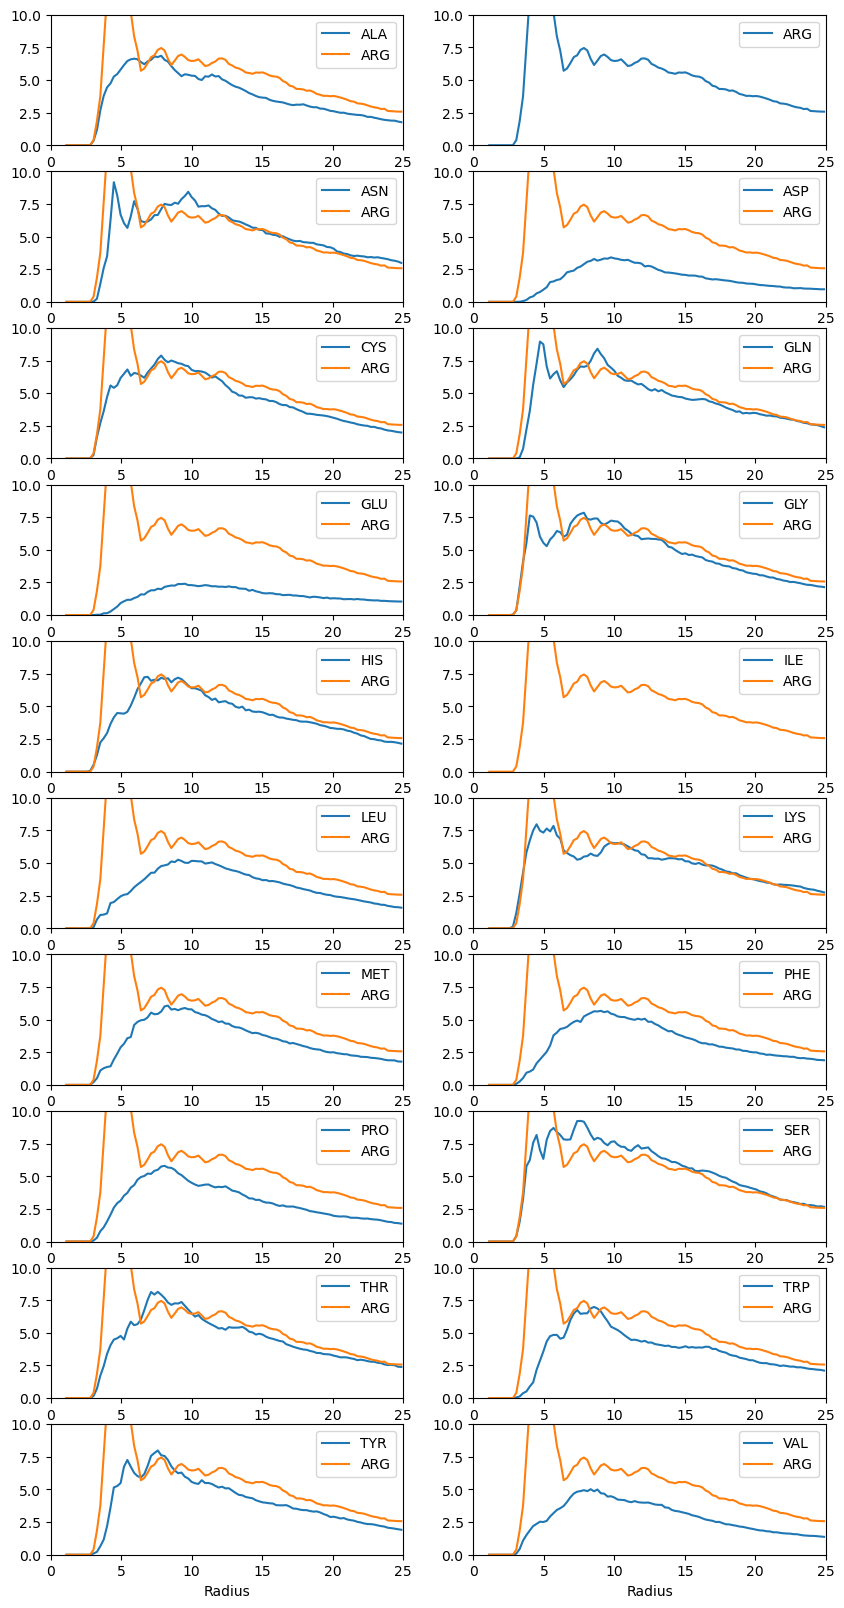

In [15]:
rdf_dict = make_dict("rdf_side-end_po4.csv", x_residue)
display_results(rdf_dict)

# By Residue

## ALA

<Figure size 640x480 with 0 Axes>

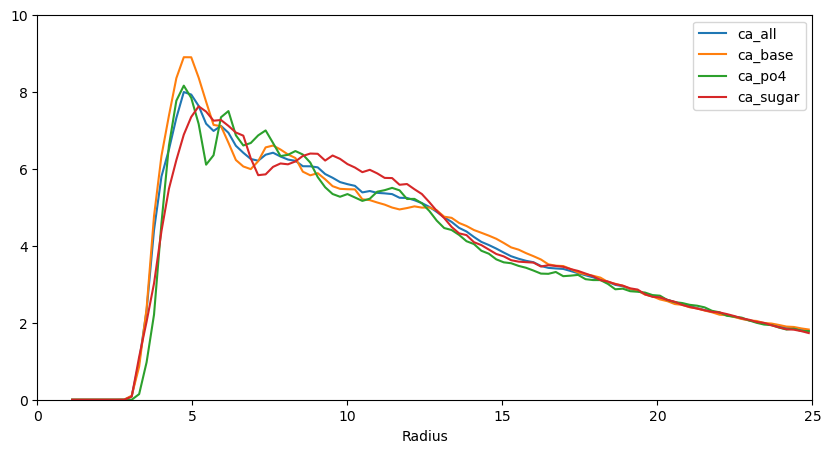

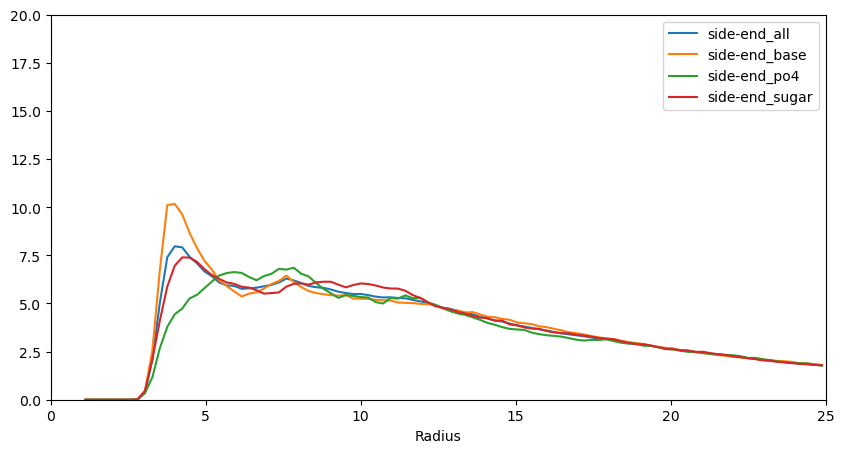

In [16]:
rdf_dict = make_res_dict(rdf_methods, "ALA")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## ARG

<Figure size 640x480 with 0 Axes>

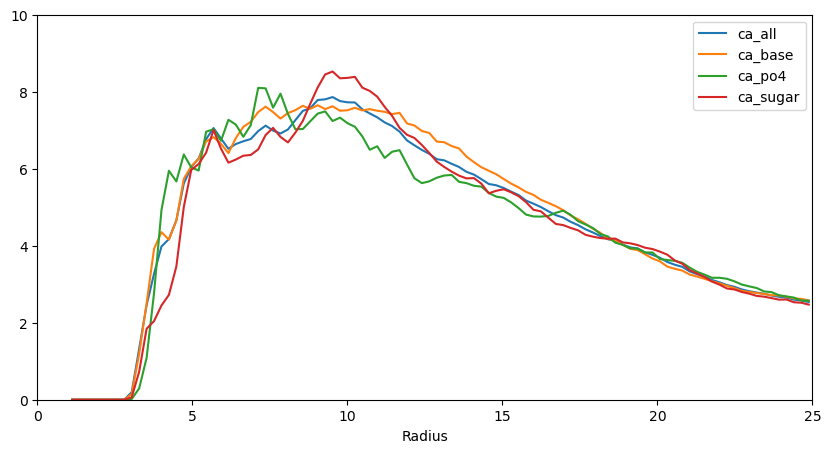

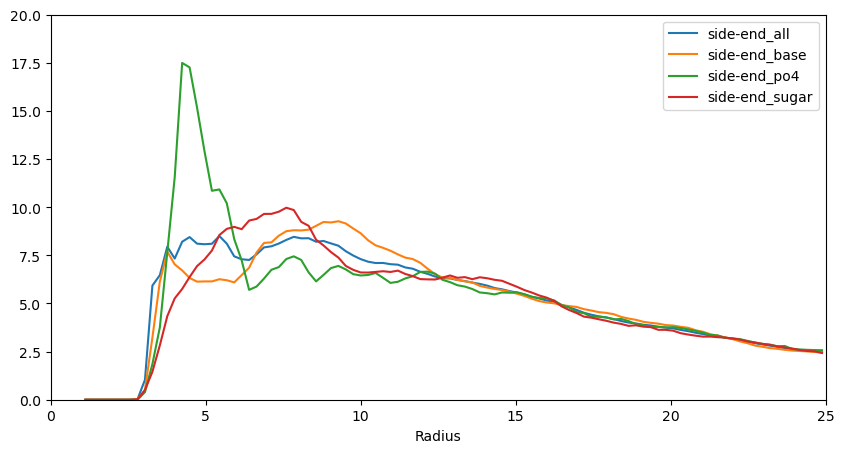

In [17]:
rdf_dict = make_res_dict(rdf_methods, "ARG")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## ASN

<Figure size 640x480 with 0 Axes>

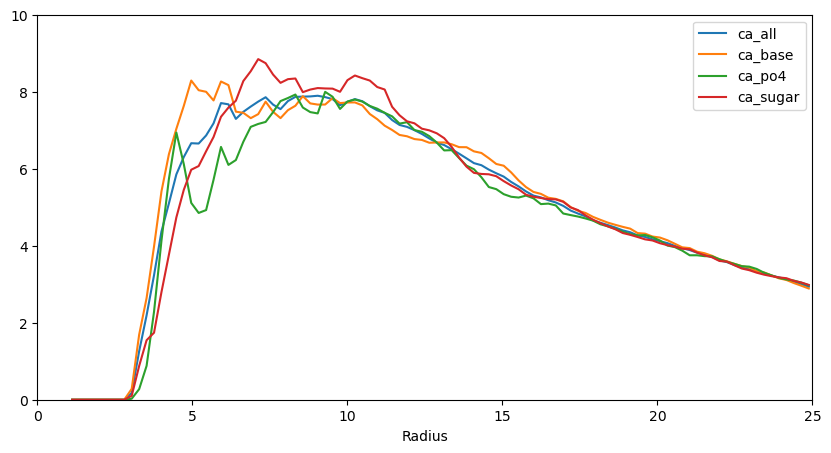

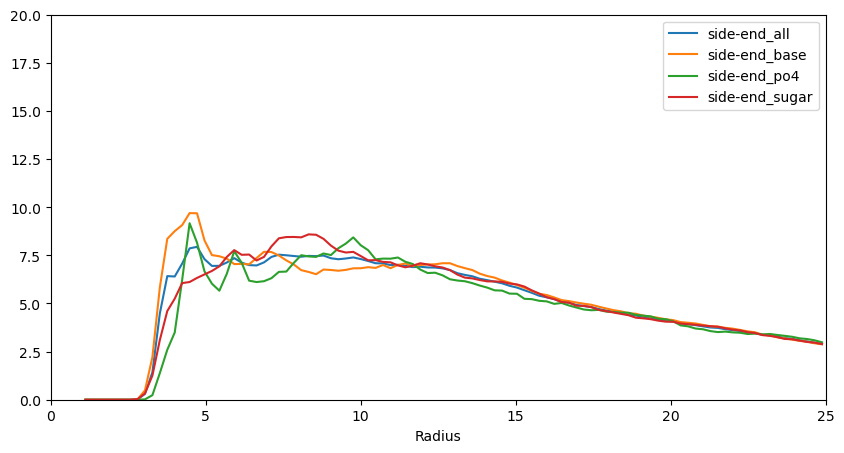

In [18]:
rdf_dict = make_res_dict(rdf_methods, "ASN")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## ASP

<Figure size 640x480 with 0 Axes>

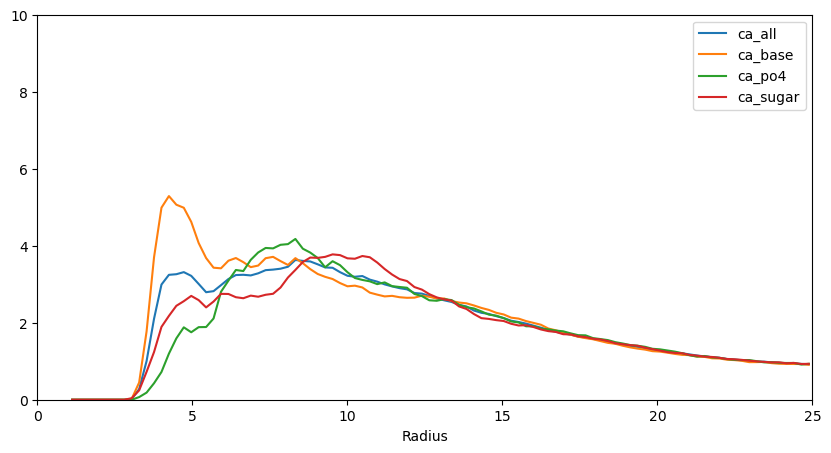

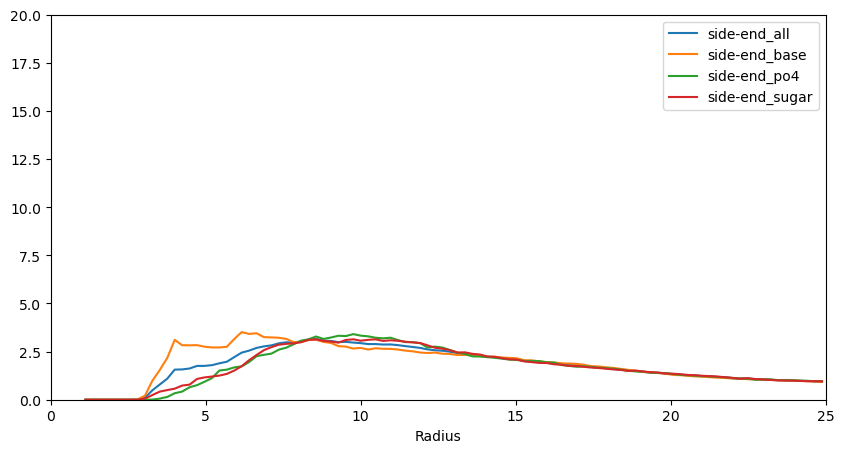

In [19]:
rdf_dict = make_res_dict(rdf_methods, "ASP")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## CYS

<Figure size 640x480 with 0 Axes>

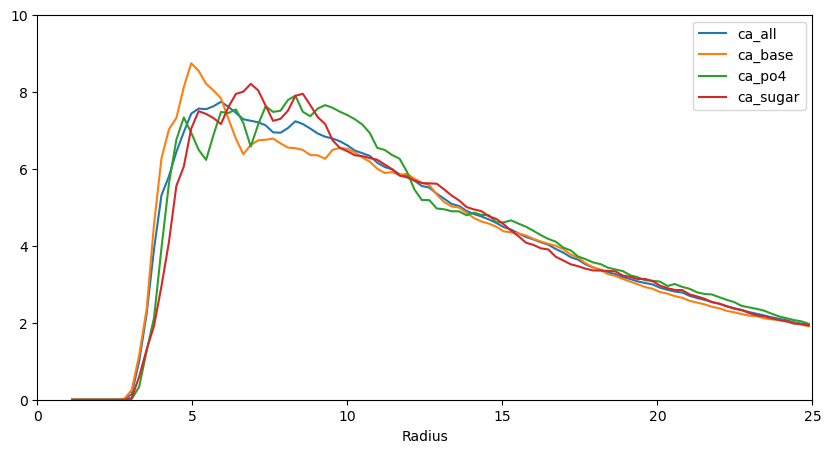

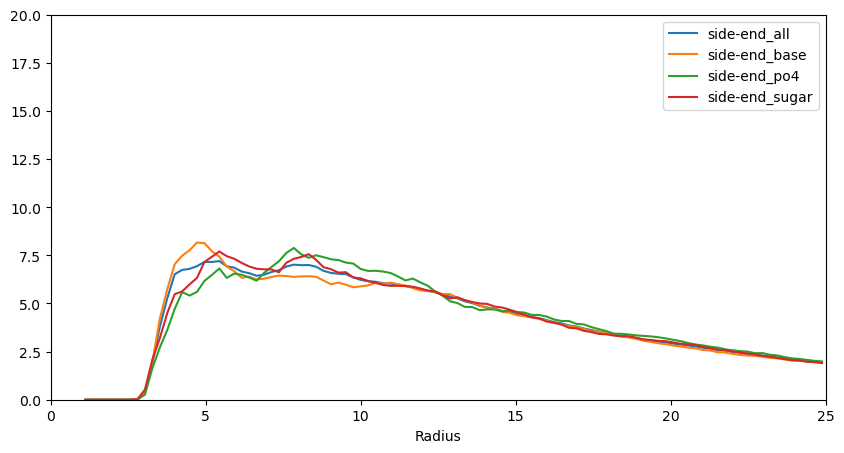

In [20]:
rdf_dict = make_res_dict(rdf_methods, "CYS")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## GLN

<Figure size 640x480 with 0 Axes>

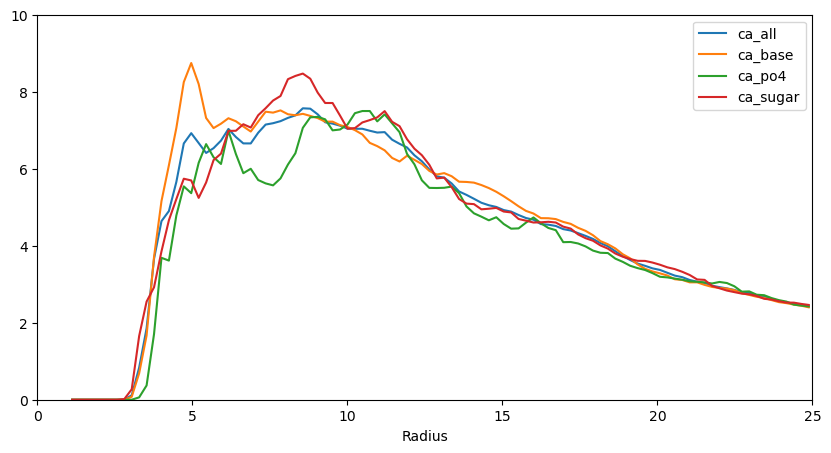

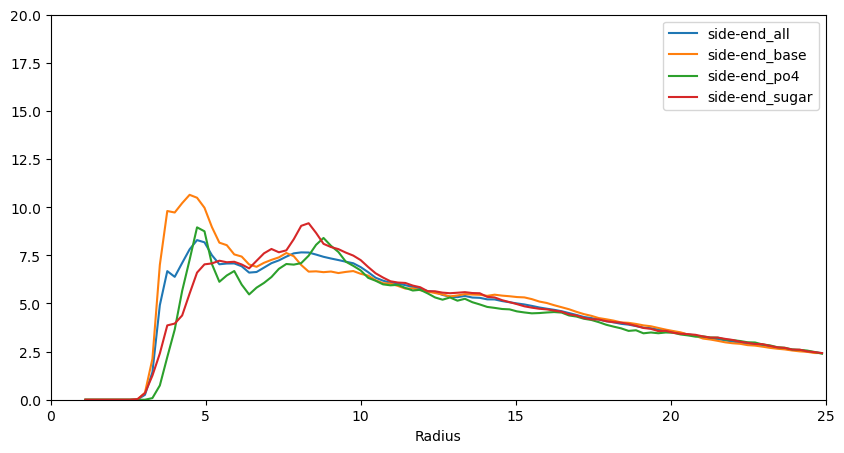

In [21]:
rdf_dict = make_res_dict(rdf_methods, "GLN")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## GLU

<Figure size 640x480 with 0 Axes>

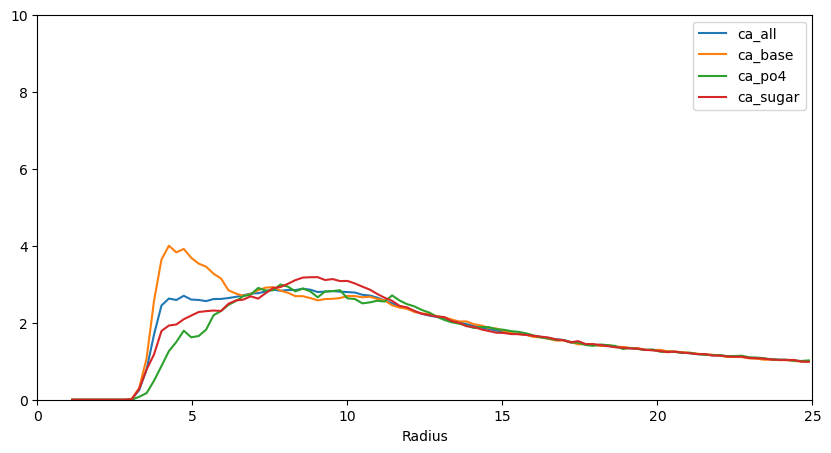

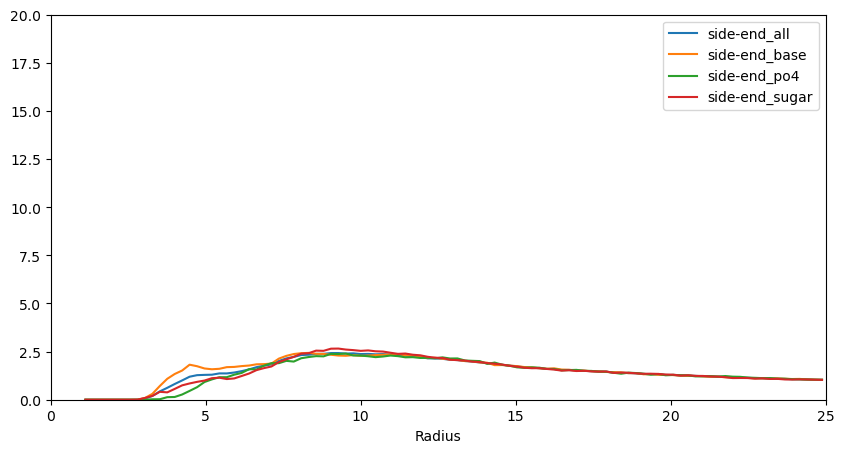

In [22]:
rdf_dict = make_res_dict(rdf_methods, "GLU")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## GLY

<Figure size 640x480 with 0 Axes>

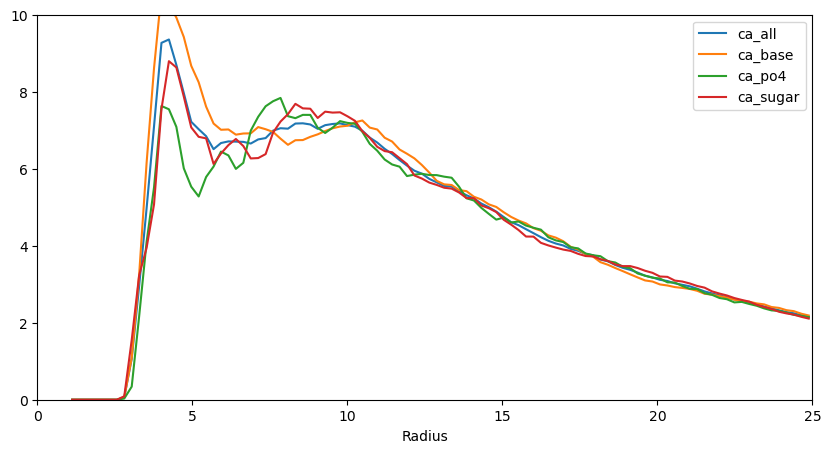

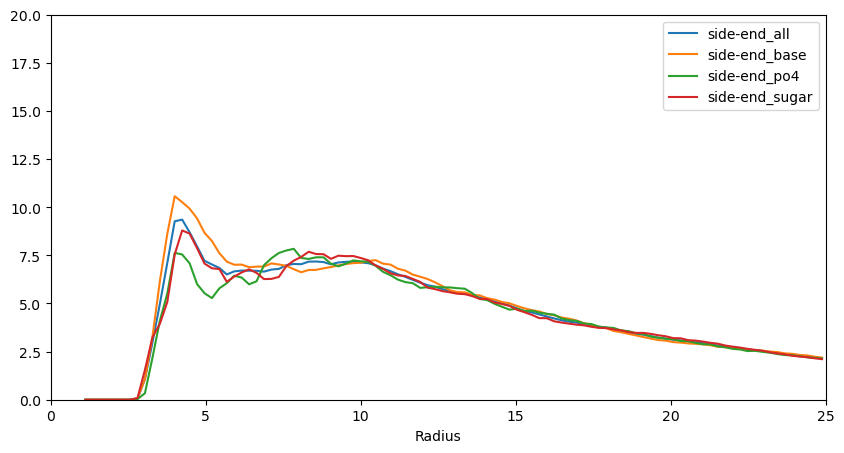

In [23]:
rdf_dict = make_res_dict(rdf_methods, "GLY")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## HIS

<Figure size 640x480 with 0 Axes>

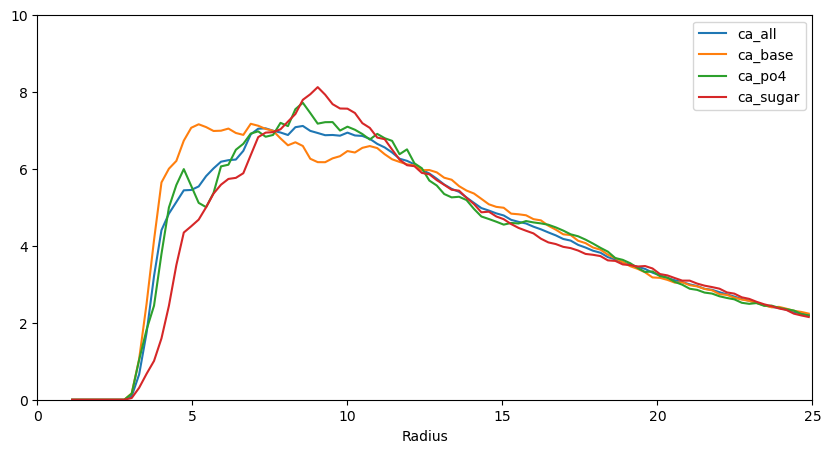

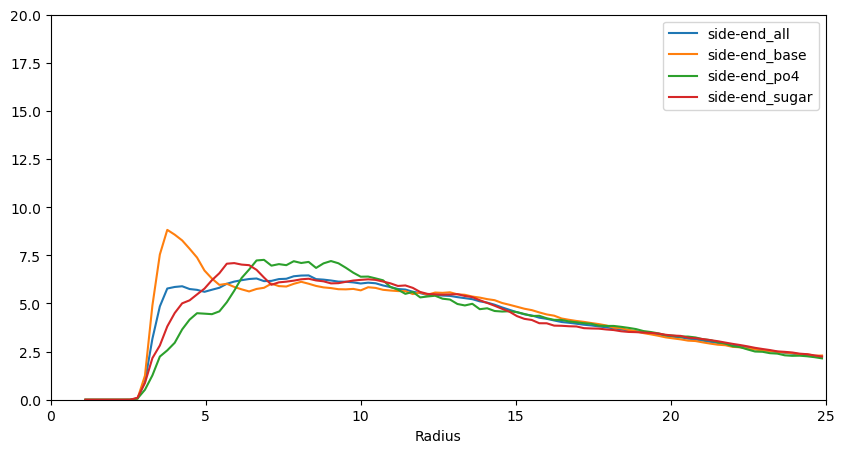

In [24]:
rdf_dict = make_res_dict(rdf_methods, "HIS")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## ILE

<Figure size 640x480 with 0 Axes>

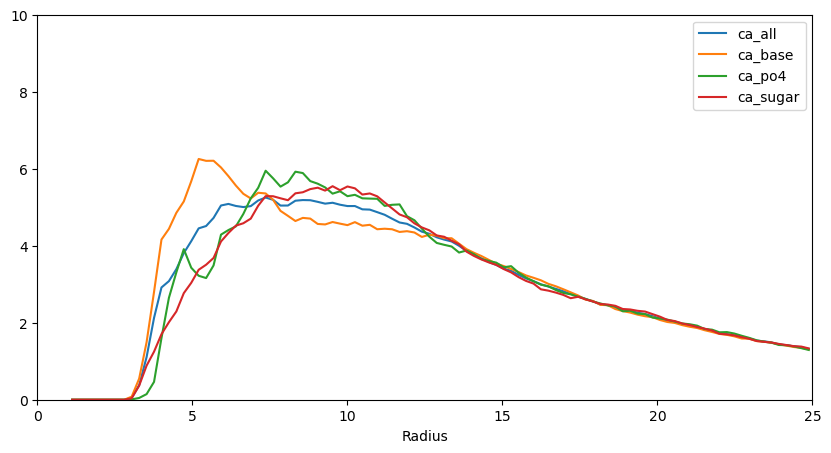

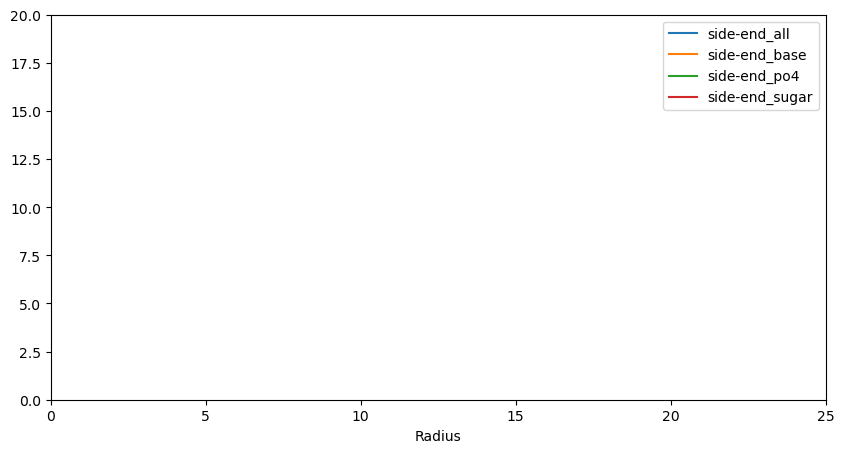

In [25]:
rdf_dict = make_res_dict(rdf_methods, "ILE")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## LEU

<Figure size 640x480 with 0 Axes>

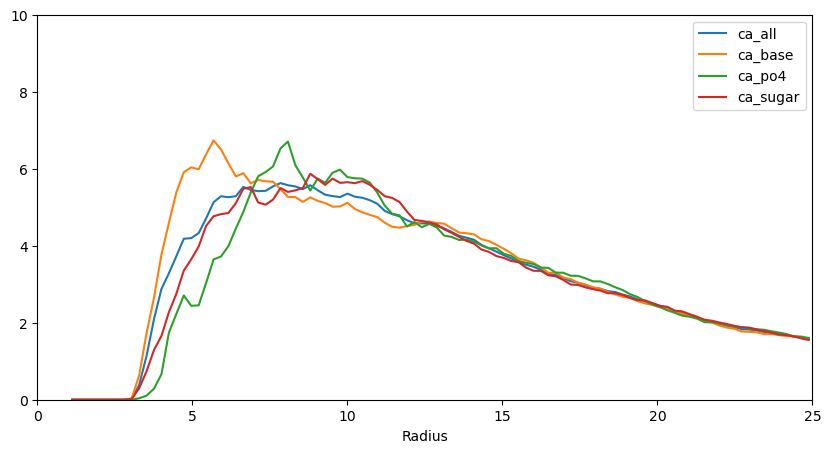

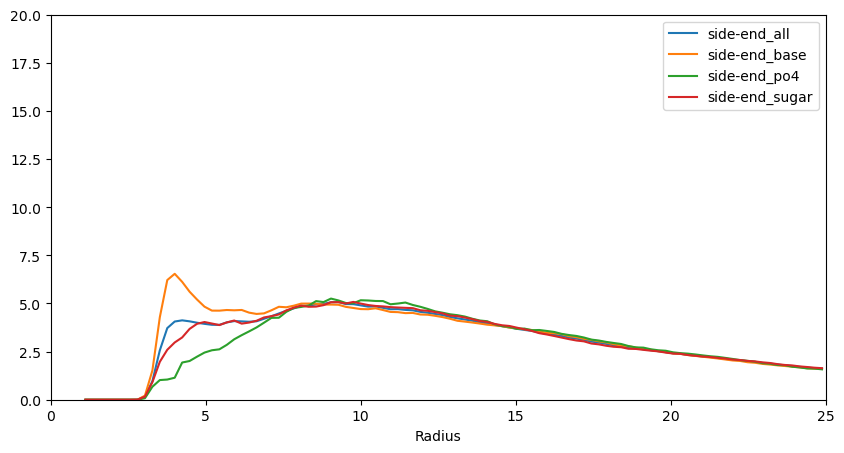

In [26]:
rdf_dict = make_res_dict(rdf_methods, "LEU")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## LYS

<Figure size 640x480 with 0 Axes>

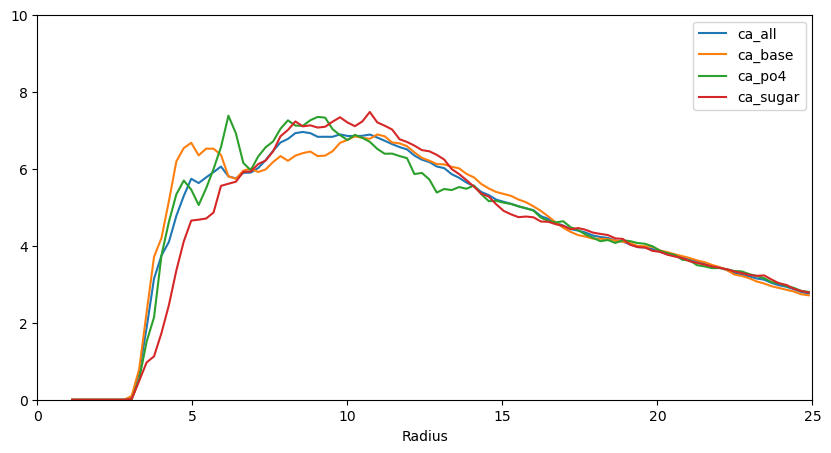

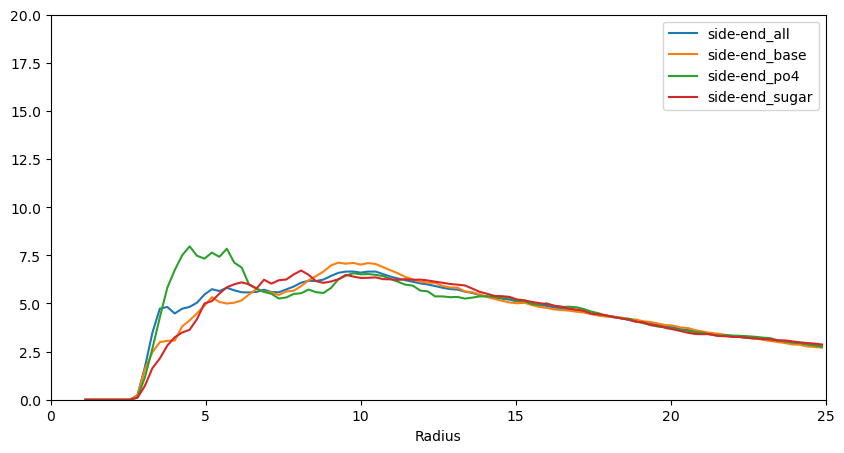

In [27]:
rdf_dict = make_res_dict(rdf_methods, "LYS")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## MET

<Figure size 640x480 with 0 Axes>

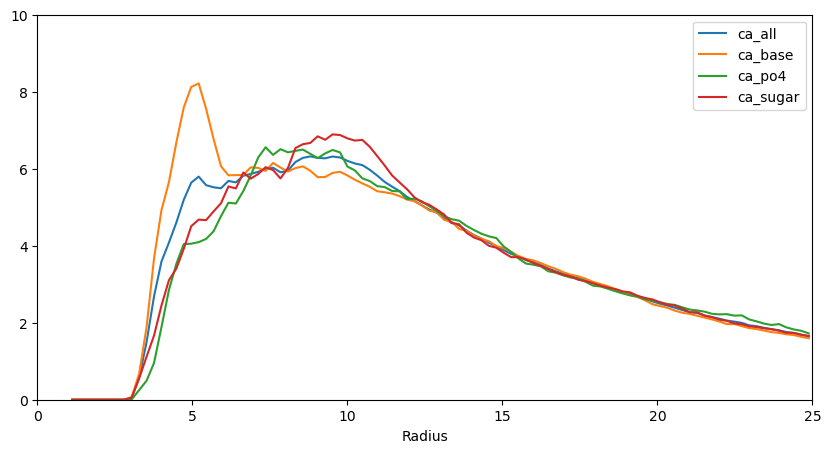

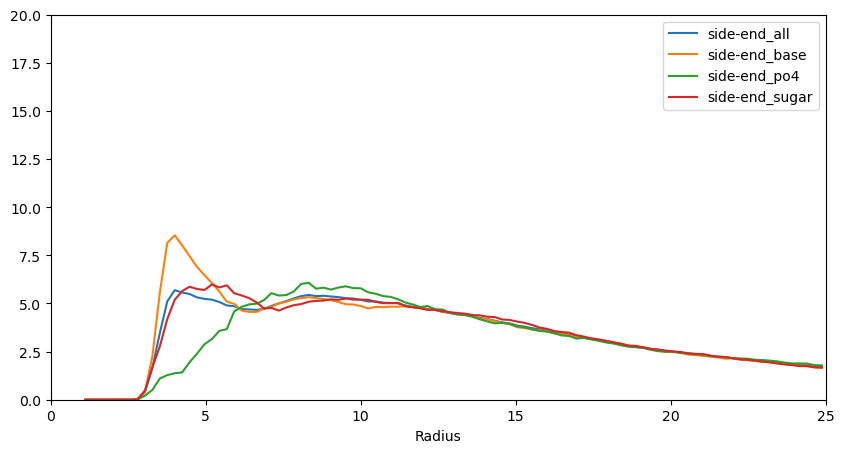

In [28]:
rdf_dict = make_res_dict(rdf_methods, "MET")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## PHE

<Figure size 640x480 with 0 Axes>

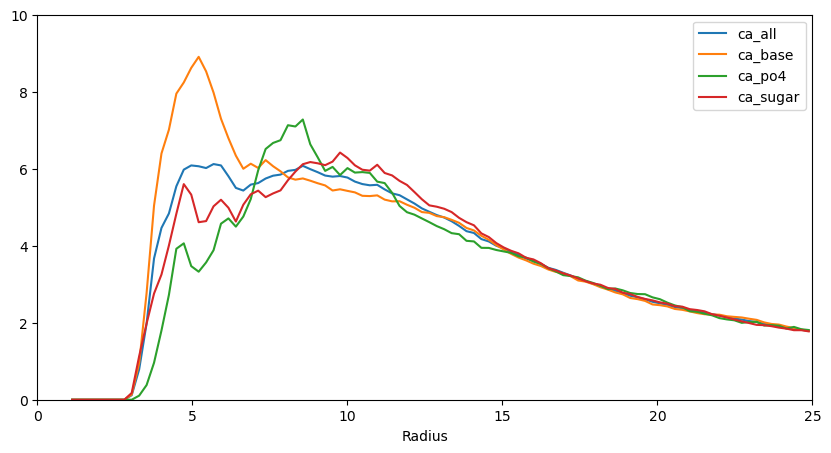

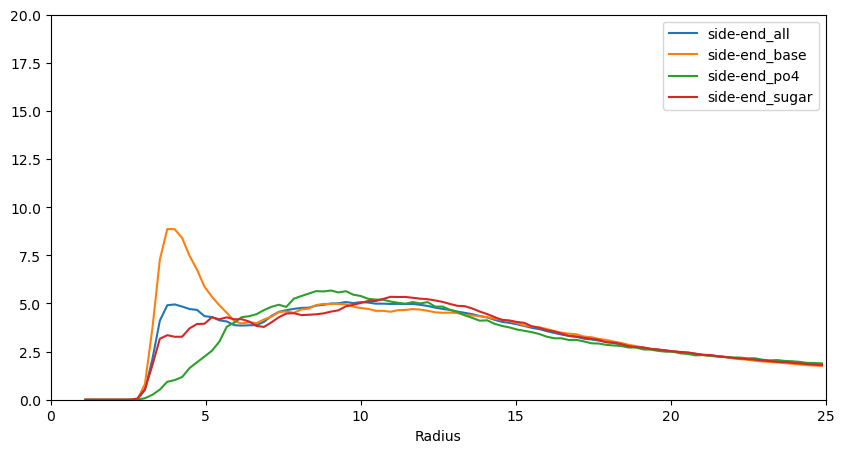

In [29]:
rdf_dict = make_res_dict(rdf_methods, "PHE")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## PRO

<Figure size 640x480 with 0 Axes>

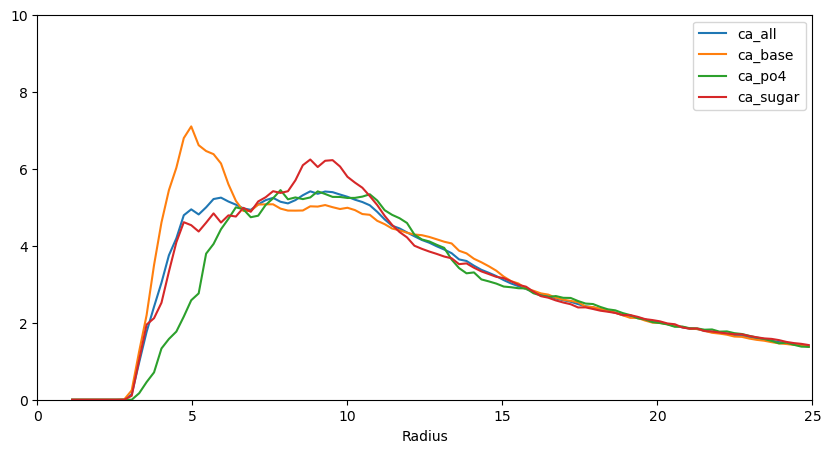

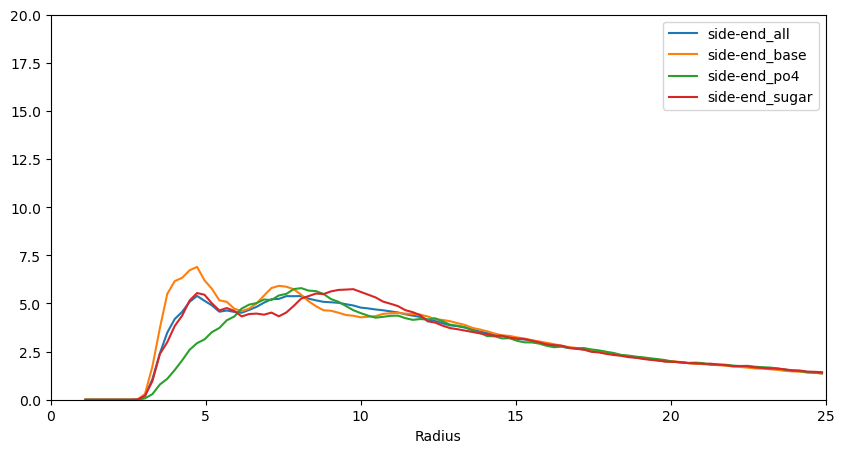

In [30]:
rdf_dict = make_res_dict(rdf_methods, "PRO")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## SER

<Figure size 640x480 with 0 Axes>

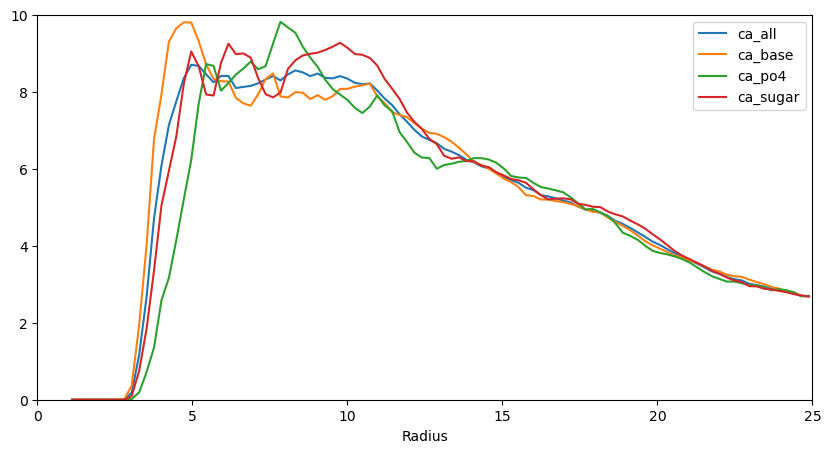

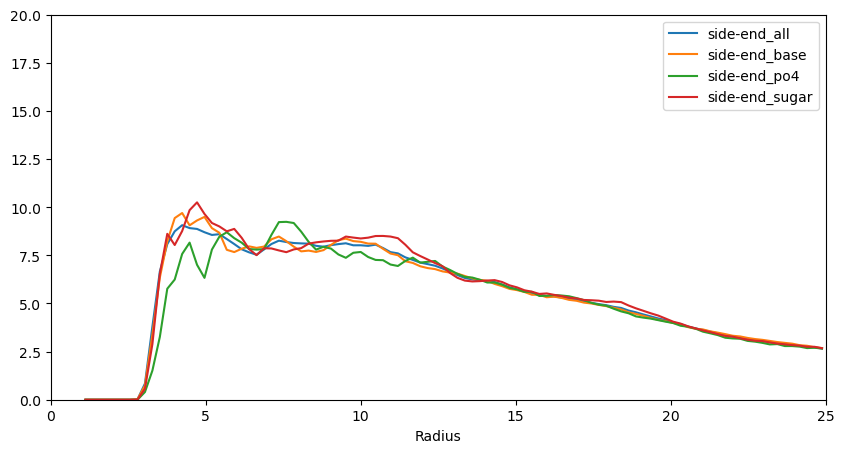

In [31]:
rdf_dict = make_res_dict(rdf_methods, "SER")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## THR

<Figure size 640x480 with 0 Axes>

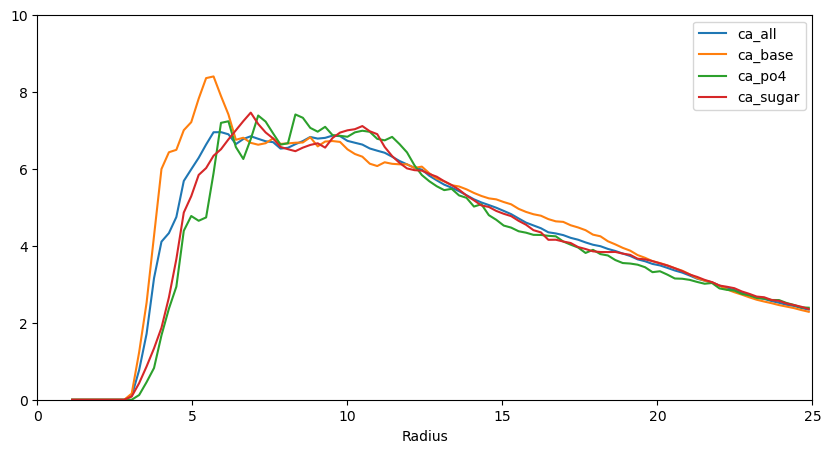

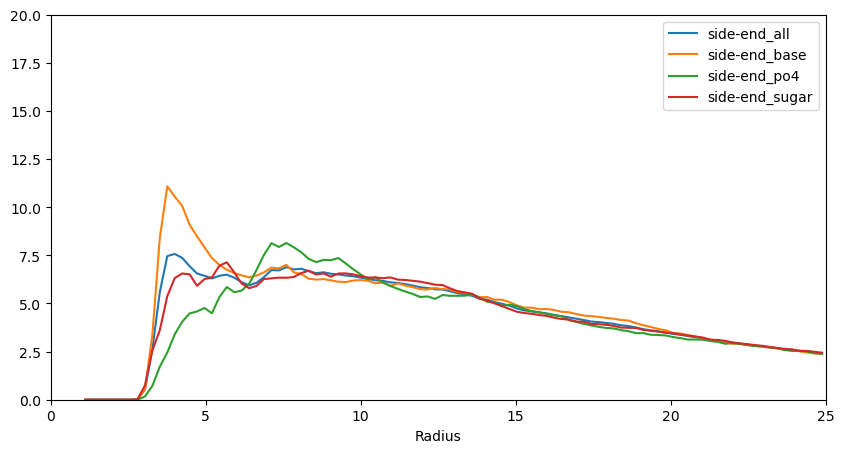

In [32]:
rdf_dict = make_res_dict(rdf_methods, "THR")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## TRP

<Figure size 640x480 with 0 Axes>

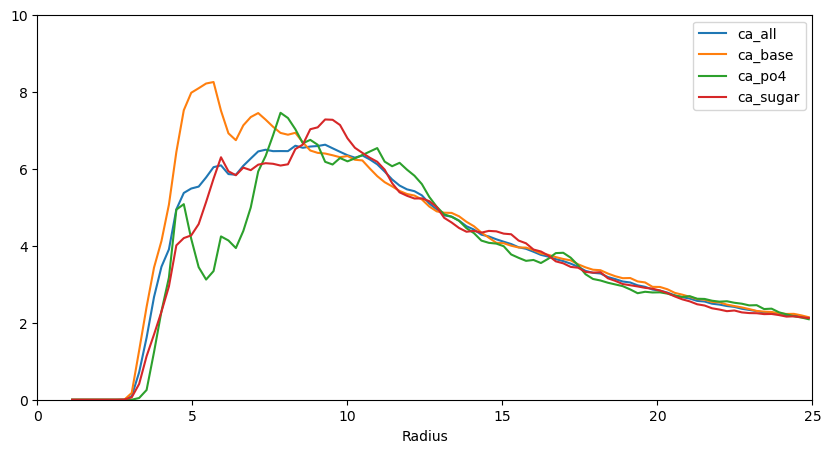

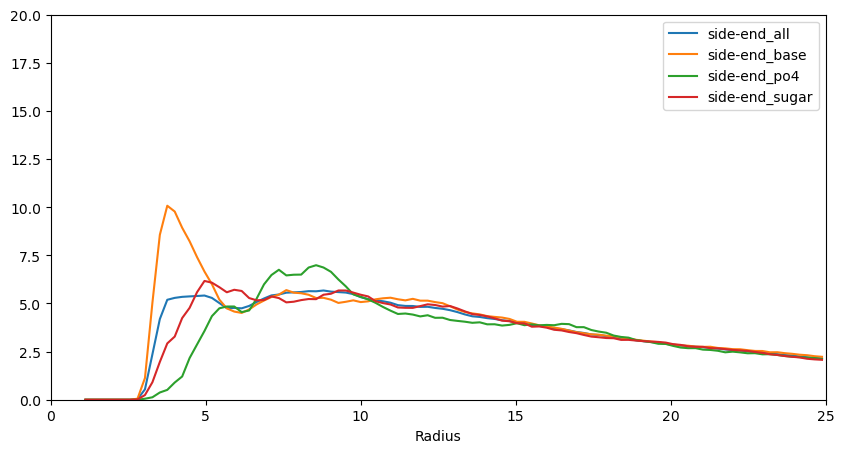

In [33]:
rdf_dict = make_res_dict(rdf_methods, "TRP")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## TYR

<Figure size 640x480 with 0 Axes>

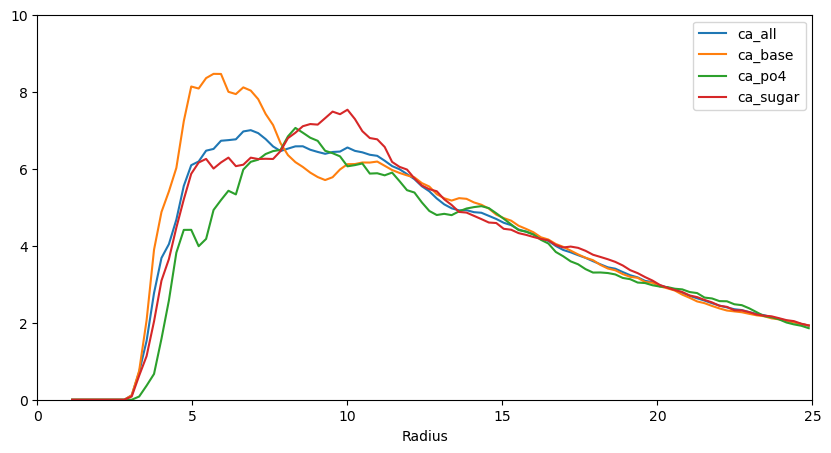

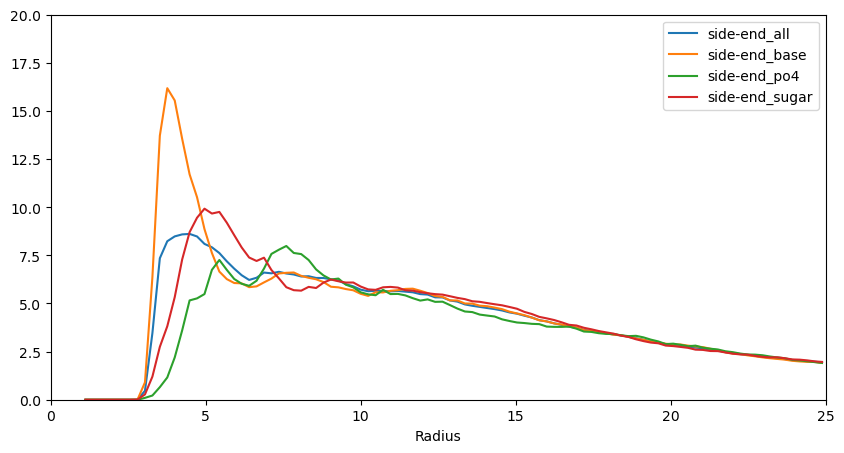

In [34]:
rdf_dict = make_res_dict(rdf_methods, "TYR")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])

## VAL

<Figure size 640x480 with 0 Axes>

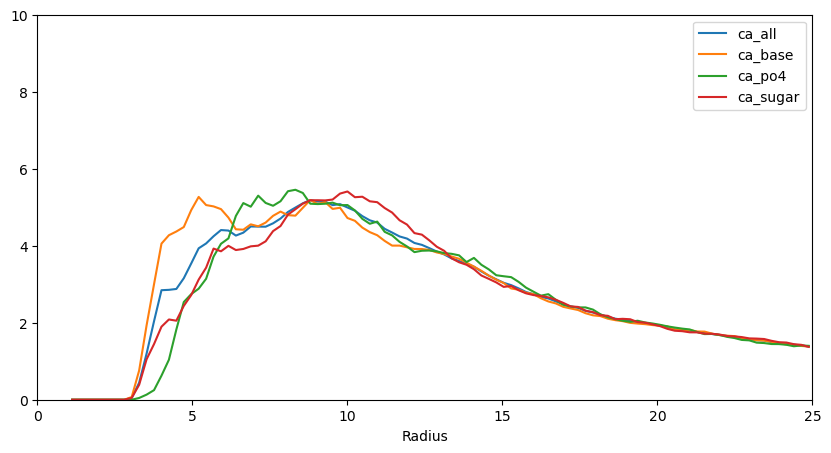

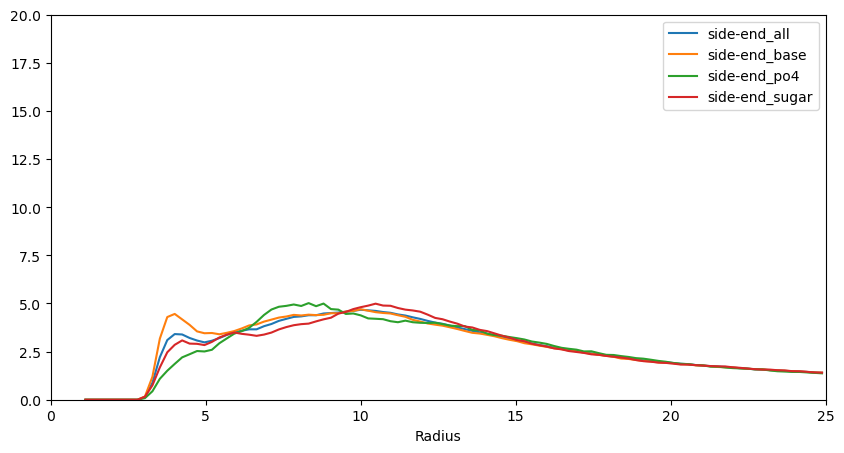

In [35]:
rdf_dict = make_res_dict(rdf_methods, "VAL")
rdf_stack_graph(rdf_dict, rdf_ca_methods, height = 5)
rdf_stack_graph(rdf_dict, rdf_side_end_methods, height = 5, y_range=[0,20])